Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot. Limit the search space of the combos to {[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, EarlyStopper
class MLP(MLP):
    def __init__(self):
        nn.Module.__init__(self)
        self.mlp_stack = nn.Sequential()

    def add_layer(self, name, layer):
        self.mlp_stack.add_module(name, layer)

# training function
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    model.train()  # inform Dropout layer to work
    for X, y in dataloader:
        # forward pass and compute loss
        pred = model(X).reshape(-1)
        loss = loss_fn(pred, y.float())

        # back-prop and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update loss and correct number
        train_loss += loss.item() * X.size(0)
        correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()
    
    train_loss /= size
    train_acc = correct / size
    return train_loss, train_acc

# validation function
def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    val_loss, correct = 0, 0
    model.eval()  # inform no dropout during validation

    with torch.no_grad():
        for X, y in dataloader:
            # forward pass
            pred = model(X).reshape(-1)
            val_loss += loss_fn(pred, y.float()).item() * X.size(0)
            
            correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    val_loss /= size
    val_acc = correct / size
    return val_loss, val_acc

# testing function
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()  # inform no dropout during testing

    with torch.no_grad():
        for X, y in dataloader:
            # forward pass
            pred = model(X).reshape(-1)
            test_loss += loss_fn(pred, y.float()).item() * X.size(0)
            correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    test_loss /= size
    test_acc = correct / size
    return test_loss, test_acc

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE
    train_accuracies, train_losses, test_accuracies, test_losses, times = [], [], [], [], []
    no_epochs = 100  # set epoch number
    lr = 0.001  # learning rate

    # set Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # initialize early stopper
    early_stopper = EarlyStopper(patience=3, min_delta=0)

    # set DataLoader
    train_dataset = CustomDataset(X_train_scaled, y_train2)
    val_dataset = CustomDataset(X_val_scaled, y_val2)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # start training
    for epoch in range(no_epochs):
        start_time = time.time()

        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)

        val_loss, val_acc = val_loop(val_dataloader, model, loss_fn)

        end_time = time.time()

        # early stop setting
        if early_stopper.early_stop(val_loss): 
            print(f"Early stopping at epoch {epoch + 1}!")
            break
        
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        test_accuracies.append(val_acc)
        test_losses.append(val_loss)
        times.append(end_time - start_time)

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [4]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    # preprocess data
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(parameters, X_train, y_train)

    no_features = 77 # feature number
    no_labels = 1  # output label number

    cross_validation_accuracies, cross_validation_times = {}, {}

    for p in parameters:
        para_str = str(p)
        accuracy = []
        last_epoch_time = []
        print(f"depth and width: {para_str}")
        
        # process parameters
        para_list = []  # layer information
        p.insert(0, no_features)
        p.append(no_labels)
        for i in range(len(p) - 1):
            para_list.append((p[i], p[i + 1]))
        
        for i in range(5):
            # initialize model
            model = MLP()
            for j in range(len(para_list)):
                if j == len(para_list) - 1:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
                else:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"ReLU{j}", nn.ReLU())
                    model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

            # choose dataset
            X_train_scaled, y_train2 = X_train_scaled_dict[para_str][i], y_train_dict[para_str][i]
            X_val_scaled, y_val2 = X_val_scaled_dict[para_str][i], y_val_dict[para_str][i]

            # start training
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)

            print(f"experiment {i + 1}: accuracy: {test_accuracies[-1]:>4f}; last epoch time {times[-1]:>4f}")
            accuracy.append(test_accuracies[-1])
            last_epoch_time.append(times[-1])
        
        cross_validation_accuracies[para_str] = accuracy
        cross_validation_times[para_str] = last_epoch_time
        print(f"depth and width {para_str}: mean accuracy: {sum(cross_validation_accuracies[para_str]) / 5:>4f}; mean last epoch time {sum(cross_validation_times[para_str]) / 5:>4f}")
        print("----")

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 256. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
from common_utils import split_dataset
# load data
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
columns_to_drop = ['filename', 'label']

def generate_cv_folds(parameters, X_train, y_train):
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}
    
    # perform 5 fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=100)
    for p in parameters:
        X_train_scaled_list, X_val_scaled_list, y_train_list, y_val_list = [], [], [], []

        for train_index, val_index in kf.split(X_train):
            # split training and validation set
            X_train_fold, X_val_fold, y_train_fold, y_val_fold = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
            scaler = preprocessing.StandardScaler()
            
            # do scaling independently on each cross validation set
            X_train_scaled_fold = scaler.fit_transform(X_train_fold)
            X_val_scaled_fold = scaler.transform(X_val_fold)
            
            # add to the list
            X_train_scaled_list.append(X_train_scaled_fold)
            X_val_scaled_list.append(X_val_scaled_fold)
            y_train_list.append(y_train_fold)
            y_val_list.append(y_val_fold)
        
        # add to the dict
        X_train_scaled_dict[str(p)] = X_train_scaled_list
        X_val_scaled_dict[str(p)] = X_val_scaled_list
        y_train_dict[str(p)] = y_train_list
        y_val_dict[str(p)] = y_val_list

            
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

# perform data splitting first
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop=columns_to_drop, test_size=0.25, random_state=100)

optimal_bs = 256
num_neurons = [[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

depth and width: [64]


D:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Early stopping at epoch 52!
experiment 1: accuracy: 0.673300; last epoch time 0.141928
Early stopping at epoch 34!
experiment 2: accuracy: 0.675511; last epoch time 0.066582
Early stopping at epoch 37!
experiment 3: accuracy: 0.662611; last epoch time 0.140172
Early stopping at epoch 68!
experiment 4: accuracy: 0.701881; last epoch time 0.138416
Early stopping at epoch 33!
experiment 5: accuracy: 0.673119; last epoch time 0.145577
depth and width [64]: mean accuracy: 0.677284; mean last epoch time 0.126535
----
depth and width: [128]
Early stopping at epoch 34!
experiment 1: accuracy: 0.683803; last epoch time 0.187116
Early stopping at epoch 39!
experiment 2: accuracy: 0.691542; last epoch time 0.174085
Early stopping at epoch 30!
experiment 3: accuracy: 0.663164; last epoch time 0.173717
Early stopping at epoch 21!
experiment 4: accuracy: 0.656527; last epoch time 0.171692
Early stopping at epoch 45!
experiment 5: accuracy: 0.706858; last epoch time 0.175547
depth and width [128]: me

Early stopping at epoch 25!
experiment 1: accuracy: 0.699281; last epoch time 0.313046
Early stopping at epoch 35!
experiment 2: accuracy: 0.731896; last epoch time 0.141591
Early stopping at epoch 21!
experiment 3: accuracy: 0.680310; last epoch time 0.287776
Early stopping at epoch 35!
experiment 4: accuracy: 0.722345; last epoch time 0.302952
Early stopping at epoch 35!
experiment 5: accuracy: 0.730642; last epoch time 0.135559
depth and width [64, 128, 256]: mean accuracy: 0.712895; mean last epoch time 0.236185
----
depth and width: [64, 256, 256]
Early stopping at epoch 25!
experiment 1: accuracy: 0.700940; last epoch time 0.384188
Early stopping at epoch 24!
experiment 2: accuracy: 0.710890; last epoch time 0.188403
Early stopping at epoch 26!
experiment 3: accuracy: 0.708518; last epoch time 0.156747
Early stopping at epoch 31!
experiment 4: accuracy: 0.726770; last epoch time 0.363495
Early stopping at epoch 30!
experiment 5: accuracy: 0.730642; last epoch time 0.355060
depth 

In [5]:
# create a table for accuracy and last epoch time
paras = list(cross_validation_accuracies.keys())
mean_accuracies = [sum(cross_validation_accuracies[p]) / len(cross_validation_accuracies[p]) for p in paras]
mean_last_epoch_times = [sum(cross_validation_times[p]) / len(cross_validation_times[p]) for p in paras]
df = pd.DataFrame({'Depth And Width': paras,
                   'Accuracy': mean_accuracies,
                   'Last Epoch Time': mean_last_epoch_times
                  })

df

,Depth And Width,Accuracy,Last Epoch Time
0,[64],0.677284,0.126535
1,[128],0.680379,0.176432
2,[256],0.696968,0.196803
3,"[64, 64]",0.682922,0.195214
4,"[128, 128]",0.719088,0.240790
5,"[256, 256]",0.744417,0.267583
6,"[64, 128]",0.700730,0.190382
7,"[128, 64]",0.717871,0.177191
8,"[128, 256]",0.728932,0.255995
9,"[64, 256]",0.715106,0.204128


4.Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot. Limit the search space of the combos to {[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]}.

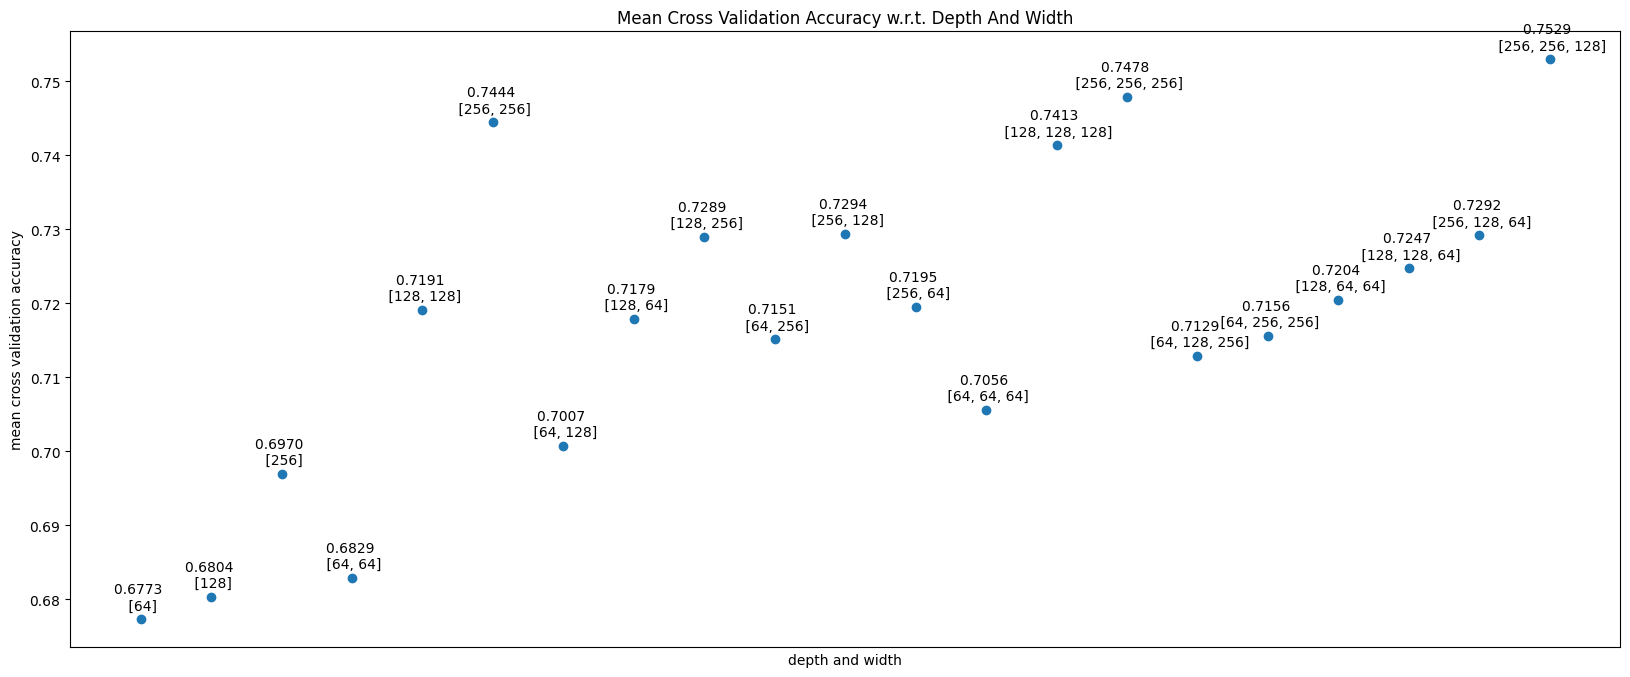

In [6]:
# YOUR CODE HERE
paras = list(cross_validation_accuracies.keys())
xt = range(1, len(paras) + 1)
plt.figure(figsize=(20, 8))
plt.xlabel('depth and width')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('mean cross validation accuracy')
plt.title('Mean Cross Validation Accuracy w.r.t. Depth And Width')
plt.scatter(xt, mean_accuracies)

for i, txt in enumerate(zip(xt, mean_accuracies)):
    plt.annotate(f'{txt[1]:.4f} \n {paras[i]}', (xt[i], mean_accuracies[i]), textcoords="offset points", xytext=(0, 7), ha='center')

5.Select the optimal combination for the depth and width. State the rationale for your selection.

In [7]:
optimal_combination = [256, 256, 128]
reason = "We choose [256, 256, 128] to be the optimal combination of the depth and width since it has the highest validation accuracy."\
         "Also, the training speed is relatively medium. Therefore, it offers the best trade-off between the performance and training speed."
# YOUR CODE HERE

6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


Epoch 1, train_loss 0.686387 train_acc 0.542026, test_loss 0.675539, test_acc 0.591376
Epoch 2, train_loss 0.667473 train_acc 0.590577, test_loss 0.661581, test_acc 0.610945
Epoch 3, train_loss 0.645028 train_acc 0.629728, test_loss 0.645958, test_acc 0.619900
Epoch 4, train_loss 0.623821 train_acc 0.649414, test_loss 0.638768, test_acc 0.648756
Epoch 5, train_loss 0.611446 train_acc 0.663570, test_loss 0.620057, test_acc 0.664345
Epoch 6, train_loss 0.584177 train_acc 0.693320, test_loss 0.608871, test_acc 0.667662
Epoch 7, train_loss 0.557974 train_acc 0.714997, test_loss 0.592201, test_acc 0.685240
Epoch 8, train_loss 0.538357 train_acc 0.725393, test_loss 0.587833, test_acc 0.684577
Epoch 9, train_loss 0.514912 train_acc 0.747622, test_loss 0.580963, test_acc 0.697512
Epoch 10, train_loss 0.492157 train_acc 0.759013, test_loss 0.557500, test_acc 0.717081
Epoch 11, train_loss 0.474398 train_acc 0.770405, test_loss 0.544223, test_acc 0.729353
Epoch 12, train_loss 0.456251 train_acc 0

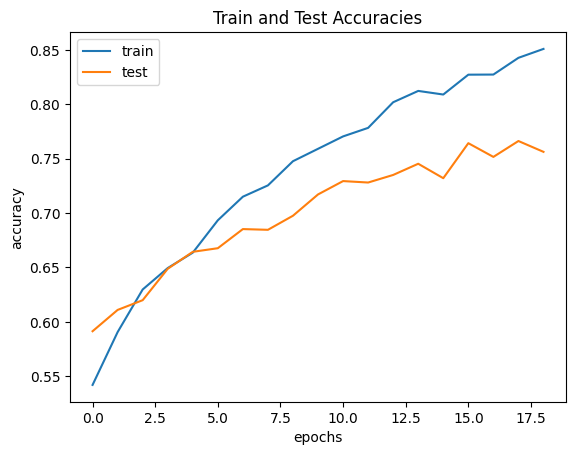

In [8]:
# YOUR CODE HERE
set_seed()
optimal_combination = [256, 256, 128]
no_features = 77 # feature number
no_labels = 1  # output label number
lr = 0.001  # learning rate

# initialize model
model = MLP()
para_list = []
optimal_combination.insert(0, no_features)
optimal_combination.append(no_labels)
for i in range(len(optimal_combination) - 1):
    para_list.append((optimal_combination[i], optimal_combination[i + 1]))
for j in range(len(para_list)):
    if j == len(para_list) - 1:
        model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
        model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
    else:
        model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
        model.add_layer(f"ReLU{j}", nn.ReLU())
        model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

# set Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

scaler = preprocessing.StandardScaler()
            
# do scaling independently on each cross validation set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# load data
train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)

# convert to DataLoader for batch processing and shuffling
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
no_epochs = 100

# initialize early stopper
early_stopper = EarlyStopper(patience=3, min_delta=0)

# start training
for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)

    print(f"Epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")
    
    # early stop setting
    if early_stopper.early_stop(test_loss): 
        print("Early stopping!")
        break
print("Done!")

# save the model
torch.save(model.state_dict(), 'model.pth')

no_epochs = len(train_acc_)

# plot accuracies
plt.figure(1)
plt.plot(range(no_epochs), train_acc_, label='train')
plt.plot(range(no_epochs), test_acc_, label ='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Train and Test Accuracies")
plt.legend()

7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

Here we use a modification of 5 fold cross validation with greedy search. We first train all 21 models on the first experiment. Then we calculate the mean accuracy of the first experiment on the validation set for each model. Then we choose the top 15 models and discard the last 6 models with the least performance. After that, we retrain these 15 models on the next experiment and choose the top 10 models having the best mean accuracy of the first 2 experiments on the validation set for each model. Then we retrain these 10 model on the next experiment and choose the top 5 models. Finally, We retrain these 5 models on the last two experiment separately and choose the one with the best mean validation accuracy of all 5 experiments.

In [9]:
# YOUR CODE HERE
# training one experiment only
def train_one_experiment(no_exp, model, X_train_scaled_list, y_train_list, X_val_scaled_list, y_val_list, batch_size):

    # choose dataset
    X_train_scaled, y_train2 = X_train_scaled_list[no_exp], y_train_list[no_exp]
    X_val_scaled, y_val2 = X_val_scaled_list[no_exp], y_val_list[no_exp]

    # start training
    train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)

    print(f"experiment {no_exp + 1}: accuracy: {test_accuracies[-1]:>4f}; last epoch time {times[-1]:>4f}")
    return test_accuracies[-1], times[-1]

# training one test only. After that, the discard operation would be done.
def train_one_test(no_total_exp, no_exp_list, para_str_list, para_dict, cross_validation_accuracies, cross_validation_times, X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict, batch_size):
    for p in para_str_list:
        print(f"depth and width: {p}")
        para_list = para_dict[p]

        for i in no_exp_list:
            # initialize model
            model = MLP()
            for j in range(len(para_list)):
                if j == len(para_list) - 1:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
                else:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"ReLU{j}", nn.ReLU())
                    model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

            # choose dataset
            X_train_scaled_list, y_train_list, X_val_scaled_list, y_val_list = X_train_scaled_dict[p], y_train_dict[p], X_val_scaled_dict[p], y_val_dict[p]

            # train one experiment
            test_acc, time = train_one_experiment(i, model, X_train_scaled_list, y_train_list, X_val_scaled_list, y_val_list, batch_size)
        
            cross_validation_accuracies[p].append(test_acc)
            cross_validation_times[p].append(time)
        print(f"depth and width {p}: mean accuracy: {sum(cross_validation_accuracies[p]) / no_total_exp:>4f}; mean last epoch time {sum(cross_validation_times[p]) / no_total_exp:>4f}")
        print("----")


def find_optimal_hyperparameter_greedy(X_train, y_train, parameters, mode, batch_size):
    # preprocess data
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(parameters, X_train, y_train)

    no_features = 77 # feature number
    no_labels = 1  # output label number

    # parameter preparation
    para_str_list = [str(i) for i in parameters]
    cross_validation_accuracies = {p: [] for p in para_str_list}
    cross_validation_times = {p: [] for p in para_str_list}
    para_dict = {}  # layer information

    for p in parameters:
        para_str = str(p)
        para_list = []
        p.insert(0, no_features)
        p.append(no_labels)
        for i in range(len(p) - 1):
            para_list.append((p[i], p[i + 1]))
        para_dict[para_str] = para_list
    
    # train the first experiment only
    print("--------------------test 1--------------------")
    train_one_test(1, [0], para_str_list, para_dict, cross_validation_accuracies, cross_validation_times, X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict, batch_size)
    sorted_dict = sorted(cross_validation_accuracies.items(), key=lambda x: x[1][0])
    print(sorted_dict)

    # discard 6 models having the least performance
    print("remove: ", end='')
    for i in range(6):
        print(sorted_dict[i][0], end=' ')
        para_str_list.remove(sorted_dict[i][0])
        cross_validation_accuracies.pop(sorted_dict[i][0])
        cross_validation_times.pop(sorted_dict[i][0])
    print()

    # train the second experiment
    print("--------------------test 2--------------------")
    train_one_test(2, [1], para_str_list, para_dict, cross_validation_accuracies, cross_validation_times, X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict, batch_size)
    sorted_dict = sorted(cross_validation_accuracies.items(), key=lambda x: x[1][0] + x[1][1])
    print(sorted_dict)

    # discard 5 models having the least performance
    print("remove: ", end='')
    for i in range(5):
        print(sorted_dict[i][0], end=' ')
        para_str_list.remove(sorted_dict[i][0])
        cross_validation_accuracies.pop(sorted_dict[i][0])
        cross_validation_times.pop(sorted_dict[i][0])
    print()

    # train the third experiment
    print("--------------------test 3--------------------")
    train_one_test(3, [2], para_str_list, para_dict, cross_validation_accuracies, cross_validation_times, X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict, batch_size)
    sorted_dict = sorted(cross_validation_accuracies.items(), key=lambda x: x[1][0] + x[1][1] + x[1][2])
    print(sorted_dict)

    # discard 5 models having the least performance
    print("remove: ", end='')
    for i in range(5):
        print(sorted_dict[i][0], end=' ')
        para_str_list.remove(sorted_dict[i][0])
        cross_validation_accuracies.pop(sorted_dict[i][0])
        cross_validation_times.pop(sorted_dict[i][0])
    print()

    # train last two experiments
    print("--------------------test 4--------------------")
    train_one_test(5, [3, 4], para_str_list, para_dict, cross_validation_accuracies, cross_validation_times, X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict, batch_size)
    sorted_dict = sorted(cross_validation_accuracies.items(), key=lambda x: x[1][0] + x[1][1] + x[1][2] + x[1][3] + x[1][4])
    print(sorted_dict)
    
    return cross_validation_accuracies, cross_validation_times

num_neurons = [[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]]

cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter_greedy(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

--------------------test 1--------------------
depth and width: [64]
Early stopping at epoch 45!
experiment 1: accuracy: 0.667219; last epoch time 0.151109
depth and width [64]: mean accuracy: 0.667219; mean last epoch time 0.151109
----
depth and width: [128]
Early stopping at epoch 32!
experiment 1: accuracy: 0.682698; last epoch time 0.219597
depth and width [128]: mean accuracy: 0.682698; mean last epoch time 0.219597
----
depth and width: [256]
Early stopping at epoch 32!
experiment 1: accuracy: 0.691542; last epoch time 0.078602
depth and width [256]: mean accuracy: 0.691542; mean last epoch time 0.078602
----
depth and width: [64, 64]
Early stopping at epoch 37!
experiment 1: accuracy: 0.686567; last epoch time 0.062505
depth and width [64, 64]: mean accuracy: 0.686567; mean last epoch time 0.062505
----
depth and width: [128, 128]
Early stopping at epoch 38!
experiment 1: accuracy: 0.723604; last epoch time 0.094171
depth and width [128, 128]: mean accuracy: 0.723604; mean last

Early stopping at epoch 43!
experiment 3: accuracy: 0.734513; last epoch time 0.188275
depth and width [128, 128]: mean accuracy: 0.726688; mean last epoch time 0.167511
----
depth and width: [256, 256]
Early stopping at epoch 35!
experiment 3: accuracy: 0.750000; last epoch time 0.141221
depth and width [256, 256]: mean accuracy: 0.741247; mean last epoch time 0.273319
----
depth and width: [128, 64]
Early stopping at epoch 42!
experiment 3: accuracy: 0.728429; last epoch time 0.097055
depth and width [128, 64]: mean accuracy: 0.722264; mean last epoch time 0.111213
----
depth and width: [128, 256]
Early stopping at epoch 38!
experiment 3: accuracy: 0.743916; last epoch time 0.259593
depth and width [128, 256]: mean accuracy: 0.746774; mean last epoch time 0.211516
----
depth and width: [256, 64]
Early stopping at epoch 35!
experiment 3: accuracy: 0.728982; last epoch time 0.250332
depth and width [256, 64]: mean accuracy: 0.726134; mean last epoch time 0.204319
----
depth and width: 

In [10]:
# create a table for accuracy and last epoch time
paras = list(cross_validation_accuracies.keys())
mean_accuracies = [sum(cross_validation_accuracies[p]) / len(cross_validation_accuracies[p]) for p in paras]
df = pd.DataFrame({'Depth And Width': paras,
                   'Accuracy': mean_accuracies
                  })

df

,Depth And Width,Accuracy
0,"[128, 128]",0.725061
1,"[256, 256]",0.733908
2,"[128, 256]",0.739657
3,"[128, 128, 128]",0.730479
4,"[256, 256, 128]",0.749613


We can see that the optimal combination of the depth and width is also [256, 256, 128]. Meanwhile, this method saves lots of time by reducing the number of training and validation periods. The rest four combinations also have relatively high accuracy shown in the plot above using the original method, showing a relatively good performance of this 5 fold cross validation with greedy search approach.